Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor as GDBT

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

Привязываем гугл-диск для загрузкии датасетов. Берем один из них для первочного анализа.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_microsoft = pd.read_csv('/content/drive/MyDrive/datasets/microsoft.csv')
df_microsoft.head(5)

,Date,Open,High,Low,Close,Volume,Currency
0,2010-01-04,30.62,31.10,30.59,30.95,38414184,USD
1,2010-01-05,30.85,31.10,30.64,30.96,49758864,USD
2,2010-01-06,30.88,31.08,30.52,30.77,58182332,USD
3,2010-01-07,30.63,30.70,30.19,30.45,50564284,USD
4,2010-01-08,30.28,30.88,30.24,30.66,51201288,USD


Берем второй датасет из геймдеав-компании для сравнения.

In [4]:
df_nintendo = pd.read_csv('/content/drive/MyDrive/datasets/nintendo.csv')
df_nintendo.head(5)

,Date,Open,High,Low,Close,Volume,Currency
0,2010-01-04,30.25,30.95,30.25,30.90,105408,USD
1,2010-01-05,31.15,32.50,31.05,31.47,210553,USD
2,2010-01-06,32.90,33.40,31.81,33.15,367749,USD
3,2010-01-07,33.90,34.35,33.90,34.22,416643,USD
4,2010-01-08,34.55,34.85,34.40,34.82,441858,USD


Аналогично смотрим на другие датасеты, чтобы проверить схожсть их формата. Далее мы анализируем один датасет, его признаки, чтобы привести его в формат, пригодный для машинного обучения.

In [5]:
df_microsoft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3191 entries, 0 to 3190
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      3191 non-null   object 
 1   Open      3191 non-null   float64
 2   High      3191 non-null   float64
 3   Low       3191 non-null   float64
 4   Close     3191 non-null   float64
 5   Volume    3191 non-null   int64  
 6   Currency  3191 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 174.6+ KB


В датасете нет пропусков. Ничего выполнять не нужно.

In [6]:
df_microsoft.Currency.value_counts()

USD    3191
Name: Currency, dtype: int64

Этот признак можно отбромить, потому что в нем тольео одно значение. Отбрасываем сразу ддля всех датафреймов, всех акций. (Конечно, до этого проверяем, что везде есть только доллары и не затесалась какая-то другая валюта.)

In [7]:
df_microsoft.drop(['Currency'], axis=1).head()

,Date,Open,High,Low,Close,Volume
0,2010-01-04,30.62,31.10,30.59,30.95,38414184
1,2010-01-05,30.85,31.10,30.64,30.96,49758864
2,2010-01-06,30.88,31.08,30.52,30.77,58182332
3,2010-01-07,30.63,30.70,30.19,30.45,50564284
4,2010-01-08,30.28,30.88,30.24,30.66,51201288


Построю матрицу корреляций, чтобы посмотреть, необходимо ли убрать какие-то признаки.

In [8]:
df_microsoft.corr()

<ipython-input-8-d5bc382a3cd7>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_microsoft.corr()


,Open,High,Low,Close,Volume
Open,1.000000,0.999909,0.999885,0.999772,-0.312391
High,0.999909,1.000000,0.999848,0.999878,-0.309798
Low,0.999885,0.999848,1.000000,0.999891,-0.316006
Close,0.999772,0.999878,0.999891,1.000000,-0.313308
Volume,-0.312391,-0.309798,-0.316006,-0.313308,1.000000


Вообще здесь везде оень высокие корреляции почти, но ценой на открытии акии и на закрытии она прям очень высокая. Попробуем "слить" их в одну переменную.

Далее есть гипотеза, что можно объединить в один признак фичи open и close и поместить в датафрейм разницу между ними вместо самих этих признаков. То есть будет 1 новая фича вместо двуз старых. При этом это должен быть новый датафрейм для постановки новых гипотез.

In [9]:
#ваш код здесь
df_beta = pd.DataFrame({
    'Date': df_microsoft['Date'],
    'Open-Close': df_microsoft['Close']-df_microsoft['Open'],
    })
df_beta.head(10)

,Date,Open-Close
0,2010-01-04,0.33
1,2010-01-05,0.11
2,2010-01-06,-0.11
3,2010-01-07,-0.18
4,2010-01-08,0.38
5,2010-01-11,-0.44
6,2010-01-12,-0.08
7,2010-01-13,0.09
8,2010-01-14,0.65
9,2010-01-15,-0.22


Далее мы помотрим каждый признак датасета на выбросы при помощи ящичковой диаграммы

<Axes: >

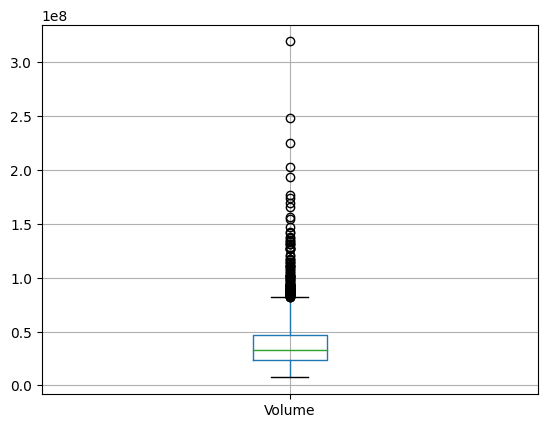

In [10]:
df_microsoft.boxplot(column=['Volume'])

Здесь мы видим, что у нас очень много выбросов. Попробем их хотя бы немного подчистить. Давайте уберем все выбросы, которые выше значения 0.6, задав им, например, среднее по фиче. Сначала найдем среднее.

In [11]:
mean = df_microsoft['Volume'].mean()
mean

38246878.50015669

Далее мы зададим каждому выбросу вот это значение среднего, а потом снова построим ящичковую диаграмму.

<Axes: >

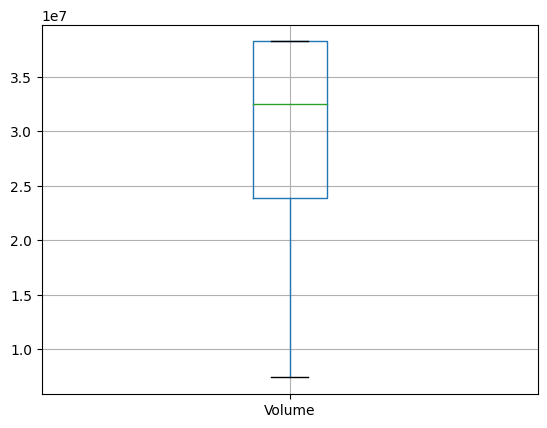

In [12]:
df_beta['Volume'] = [df_microsoft['Volume'][i] if df_microsoft['Volume'][i] <= mean else mean for i in range(df_microsoft.shape[0])]
df_beta.boxplot(column=['Volume'])

In [32]:
def outflies_away(df):
    mean = df.mean()
    df = [df[i] if df[i] <= mean else mean for i in range(len(df))]
    return pd.Series(df)

Netflix 0.4423
act_bliz 0.1171
ea 0.0987
microsoft 0.1555
nintendo 0.0071
take_two 0.212
tencent 0.2173
ubisoft 0.0607
zynga 0.0101
MEAN SCORE: 0.14675555555555556


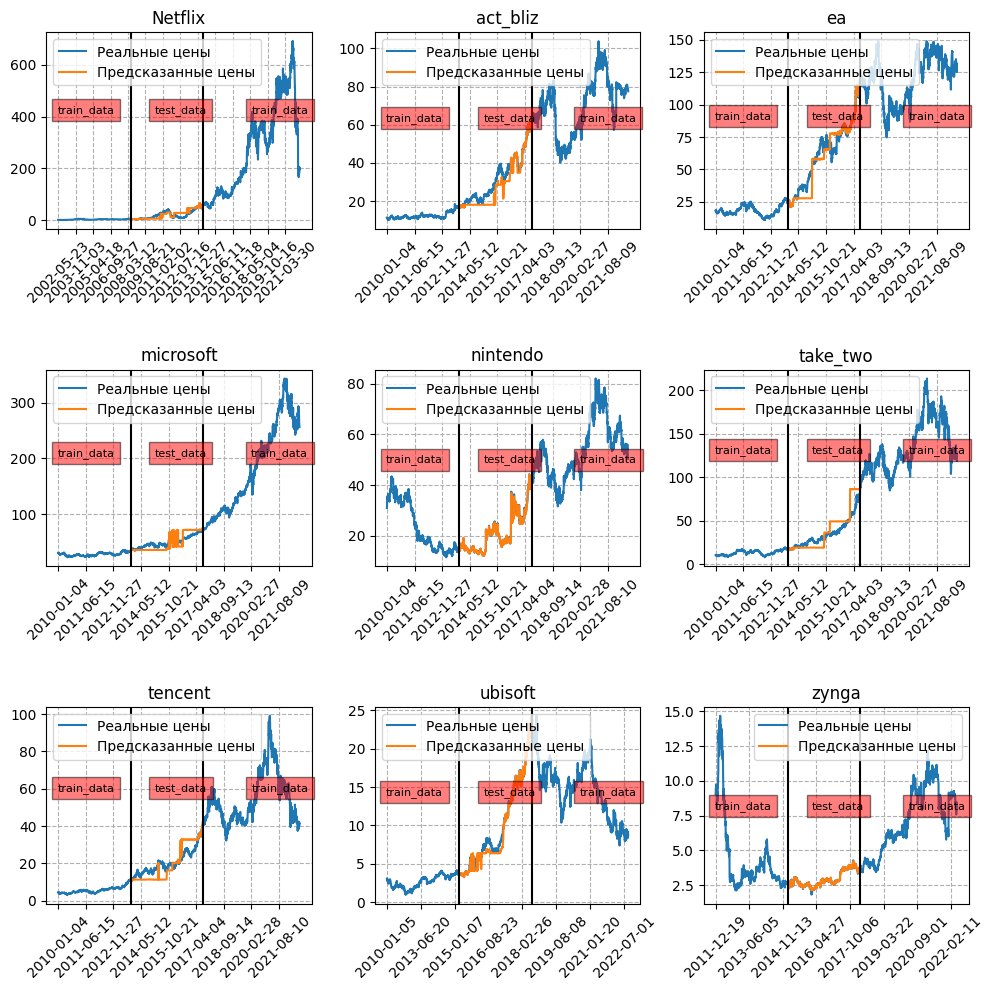

In [55]:
file_path = sorted(glob('drive/MyDrive/datasets/*.csv'))

def normalize(data):
    data['Year'] = [int(data['Date'][i][:4]) for i in range(data.shape[0])]
    data['Month'] = [int(data['Date'][i][5:7]) for i in range(data.shape[0])]
    data['Day'] = [int(data['Date'][i][8:]) for i in range(data.shape[0])]
    data['Date_int'] = data['Year']*365+data['Month']*30+data['Day']
    return data

i = 1
s = []
plt.rcParams['figure.figsize'] = [10,10]
model = RandomForestRegressor(bootstrap = True)
for f in file_path:
    df = normalize(pd.read_csv(f))

    l = int(df.shape[0]*0.3)
    r = int(df.shape[0]*0.6)

    y = df['Close']
    y_train = y
    X = df.drop(columns = ['Close', 'Date'])
    if 'Currency' in df.columns:
        X = X.drop(columns = ['Currency'])

    X_train = pd.concat([X[:l], X[r:]])
    y_train = pd.concat([y_train[:l], y_train[r:]])
    X_test = X[l:r]
    y_test = y[l:r]

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    plt.subplot(3,3, i)
    plt.tight_layout(h_pad = 3)
    metrics = round(mean_absolute_percentage_error(y_test, preds), 4)
    print(f[23:-4], metrics)
    s += [metrics]
    plt.plot(df['Date'], y)
    plt.plot(df['Date'][l:r], preds)
    plt.grid(linestyle = '--')
    plt.axvline(x = l, color = 'k', label = 'axvline - full height')
    plt.axvline(x = r, color = 'k', label = 'axvline - full height')
    shape = df.shape[0]
    plt.text(-10, int(y.max()*0.6), 'train_data', fontsize = 8, bbox = dict(facecolor = 'red', alpha = 0.5))
    plt.text(int(shape*0.4), int(y.max()*0.6), 'test_data', fontsize = 8, bbox = dict(facecolor = 'red', alpha = 0.5))
    plt.text(int(shape*0.8), int(y.max()*0.6), 'train_data', fontsize = 8, bbox = dict(facecolor = 'red', alpha = 0.5))
    plt.legend(('Реальные цены','Предсказанные цены'))
    plt.xticks(np.arange(0, df.shape[0], 365), rotation = 45)
    plt.title(f[23:-4])
    i += 1
print('MEAN SCORE:', np.mean(s))
plt.show()

Рост акций всех компаний

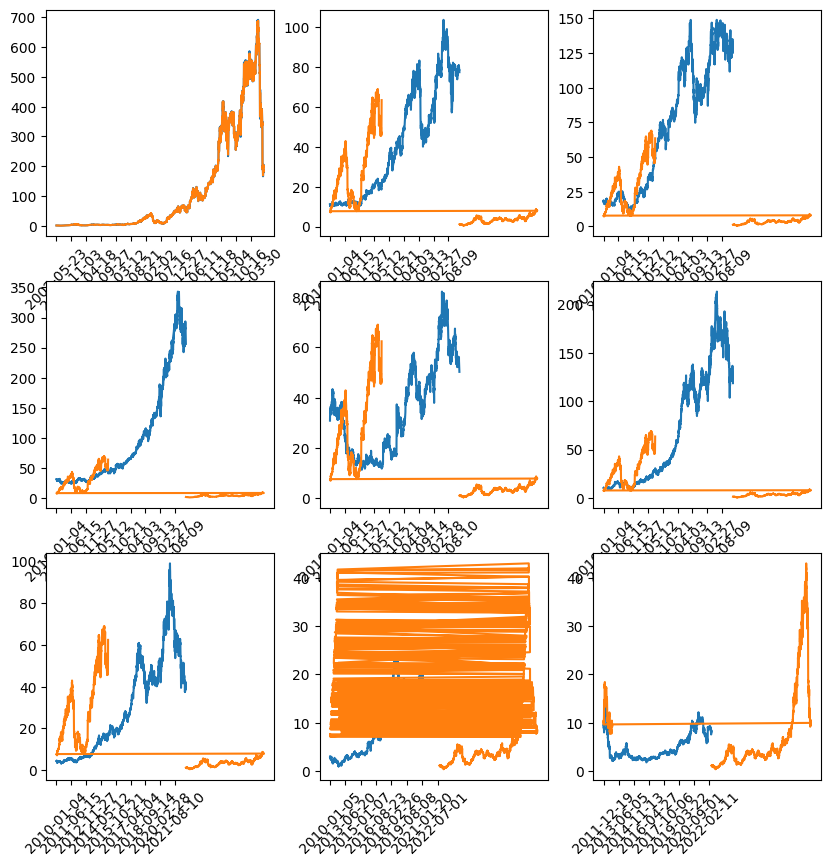

In [71]:
df = pd.concat([normalize(pd.read_csv(f)) for f in file_path])
X = df.drop(columns = ['Close', 'Currency', 'Adj Close'])
y = df['Close']

model.fit(X.drop(columns = ['Date']),y)
preds = model.predict(X.drop(columns = ['Date']))

X['Close'] = preds
X = X.drop_duplicates(subset = ['Date'])

i = 1
for f in file_path:
    df = pd.read_csv(f)
    plt.subplot(3,3, i)
    shape = df.shape[0]
    plt.plot(df['Date'], df['Close'])
    plt.plot(X['Date'][:shape], X['Close'][:shape])
    plt.xticks(np.arange(0, df.shape[0], 365), rotation = 45)
    i += 1
plt.show()

Data size: (3191, 11)
         Date   Open   High    Low  Close    Volume Currency  Year  Month  \
0  2010-01-04  30.62  31.10  30.59  30.95  38414184      USD  2010      1   
1  2010-01-05  30.85  31.10  30.64  30.96  49758864      USD  2010      1   
2  2010-01-06  30.88  31.08  30.52  30.77  58182332      USD  2010      1   
3  2010-01-07  30.63  30.70  30.19  30.45  50564284      USD  2010      1   
4  2010-01-08  30.28  30.88  30.24  30.66  51201288      USD  2010      1   
5  2010-01-11  30.71  30.76  30.12  30.27  68754648      USD  2010      1   
6  2010-01-12  30.15  30.40  29.91  30.07  65913228      USD  2010      1   
7  2010-01-13  30.26  30.52  30.01  30.35  51863464      USD  2010      1   
8  2010-01-14  30.31  31.10  30.26  30.96  63244768      USD  2010      1   
9  2010-01-15  31.08  31.24  30.71  30.86  79915648      USD  2010      1   

   Day  Date_int  
0    4    733684  
1    5    733685  
2    6    733686  
3    7    733687  
4    8    733688  
5   11    733691

In [ ]:
l,r = int(data_train.shape[0]*0.2), int(data_train.shape[0]*0.5)
model = RandomForestRegressor()
y = pd.concat([data_train['Close'][:l],data_train['Close'][r:]])
features = ['Year', 'Date_int']
X = pd.concat([data_train[features][:l],data_train[features][r:]])
model.fit(X, y)
preds = model.predict(X)
print(mean_absolute_percentage_error(y, preds))

0.00369844411654941


MAPE: 11.78 %


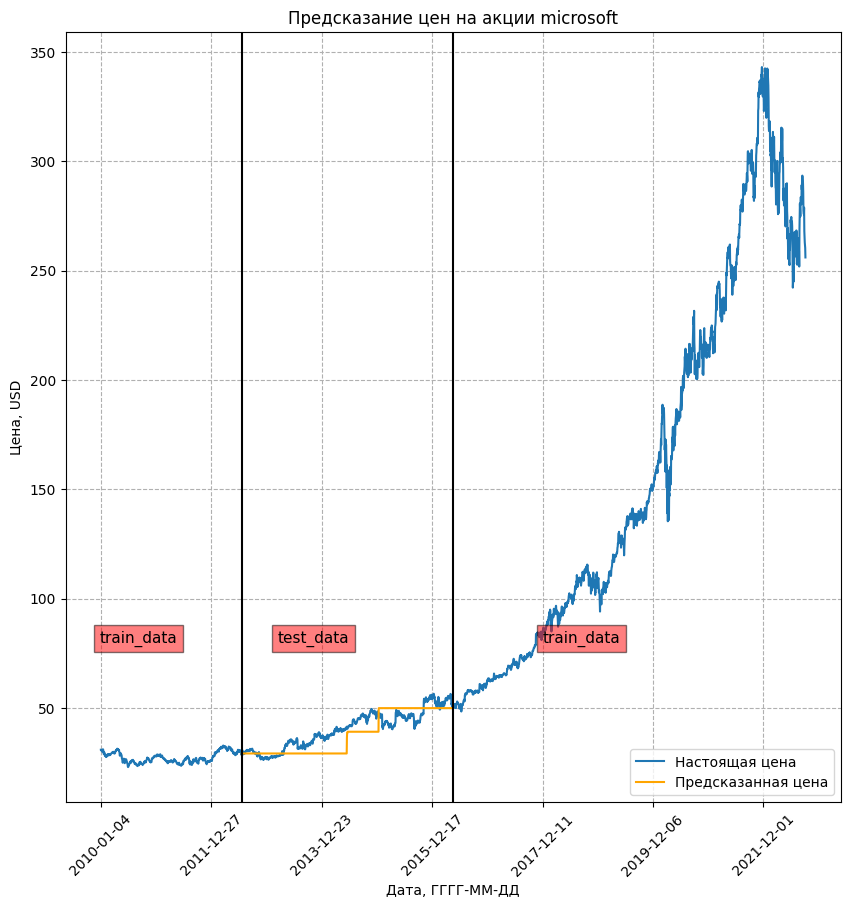

In [ ]:
preds = model.predict(data_train[features][l:r])
print('MAPE:', round(mean_absolute_percentage_error(data_train['Close'][l:r], preds), 4)*100, '%')

plt.plot(data_train['Date'], data_train['Close'])
plt.plot(data_train['Date'][l:r], preds, color = 'orange')

plt.xticks(np.arange(0, data_train.shape[0], 500), rotation = 45)
plt.grid(linestyle = '--')
plt.axvline(x = l, color = 'k', label = 'axvline - full height')

plt.axvline(x = r, color = 'k', label = 'axvline - full height')
plt.text(-5, 80, 'train_data', fontsize = 11, bbox = dict(facecolor = 'red', alpha = 0.5))
plt.text(800, 80, 'test_data', fontsize = 11, bbox = dict(facecolor = 'red', alpha = 0.5))
plt.text(2000, 80, 'train_data', fontsize = 11, bbox = dict(facecolor = 'red', alpha = 0.5))

plt.title('Предсказание цен на акции '+file_name[:-4])
plt.xlabel('Дата, ГГГГ-ММ-ДД')
plt.ylabel('Цена, USD')
plt.legend(('Настоящая цена', 'Предсказанная цена'))

plt.show()

         Date   Open   High    Low  Close    Volume Currency  Year  Month  \
0  2010-01-04  30.62  31.10  30.59  30.95  38414184      USD  2010      1   
1  2010-01-05  30.85  31.10  30.64  30.96  49758864      USD  2010      1   
2  2010-01-06  30.88  31.08  30.52  30.77  58182332      USD  2010      1   
3  2010-01-07  30.63  30.70  30.19  30.45  50564284      USD  2010      1   
4  2010-01-08  30.28  30.88  30.24  30.66  51201288      USD  2010      1   

   Day  Date_int  
0    4    733684  
1    5    733685  
2    6    733686  
3    7    733687  
4    8    733688  


<ipython-input-162-17f9de1e7ffb>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correl = data_train.corr()


<Axes: >

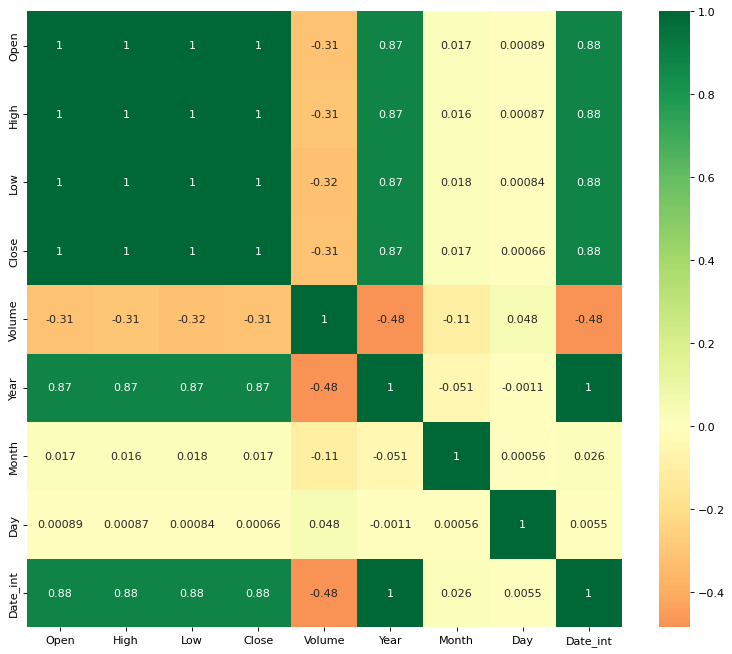

In [ ]:
print(data_train.head())
correl = data_train.corr()
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(correl, xticklabels=correl.columns, yticklabels=correl.columns, cmap='RdYlGn', center=0, annot=True)

<ipython-input-228-ea67741431e5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_summary['Close'] = preds


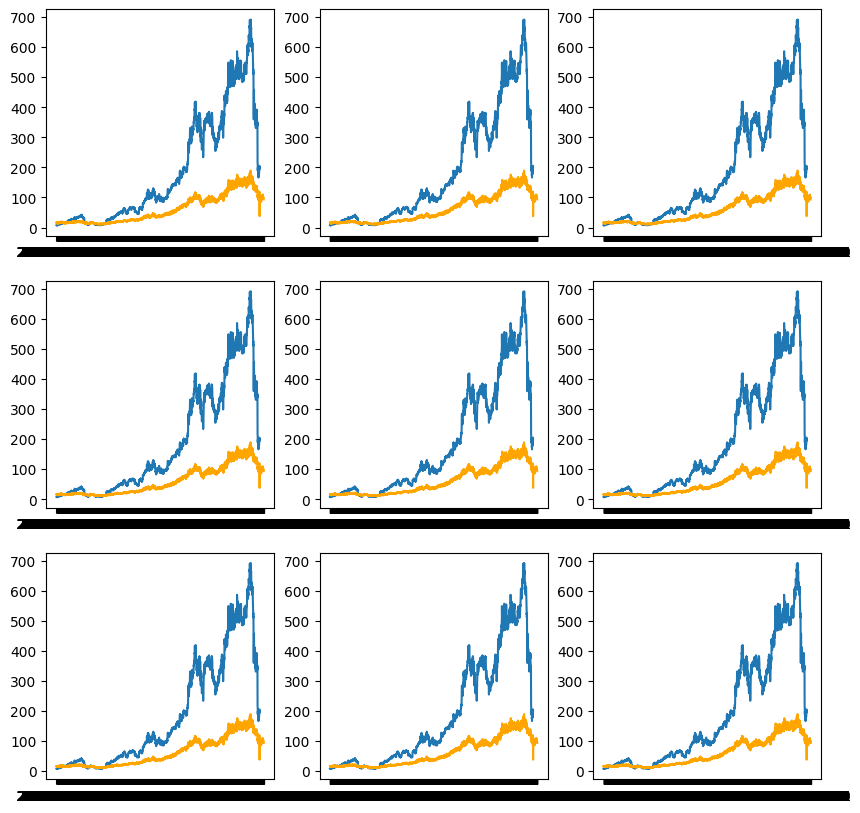

In [ ]:
df = pd.concat(all_data)
df = df.reset_index()
df = normalize(df)

y = df['Close']
X = df[['Date']+features]
model.fit(X[features], y)
preds = model.predict(X[features])
data_summary = X
data_summary['Close'] = preds
data_summary = data_summary.drop_duplicates()

for i in range(9):
    plt.subplot(3,3, i+1)
    plt.plot(all_data[i]['Date'], all_data[i]['Close'])
    plt.plot(data_summary['Date'], data_summary['Close'], color = 'orange')
plt.show()